In [1]:
!pip install openpyxl
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://ci-nexus.ai-knows.com/repository/pypi-local-aiq/simple
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl.metadata (1.8 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Looking in indexes: https://pypi.org/simple, https://ci-nexus.ai-knows.com/repository/pypi-local-aiq/simple
  Using cached japanize_matplotlib-1.1.3-py3-none-any.whl


In [2]:
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools
from aiq_strategy_robot.data.data_accessor import DAL
from aiq_strategy_robot.data.FACTSET import load_factset_fundamental_estimates
if 'sample_notebooks' not in sys.path:
    sys.path.append('sample_notebooks')
from libs.dataset import aiq_pos_csmr_goods as sc_goods
from libs.dataset import common as sc_common
from libs.path import DEFAULT_DIR
import japanize_matplotlib

# データ読み込み

In [3]:
sdh = DAL()

# POSデータ
data_id_alt = sc_goods.register_csmr_goods_data(sdh, data_dir=DEFAULT_DIR)
alt_W_id = sdh.transform.raw(data_id=data_id_alt).variable_ids[0]

# sales(YoY)データ
data_id_funda = sc_common.register_fundamental(sdh)
funda_Q_id = sdh.transform.raw(data_id=data_id_funda).variable_ids[0]

In [4]:
# コンセンサス予想
## 締日時点のコンセンサス予想を使用
h1 = sdh.load('FACTSET', data_type='symbol_lookup',
              ticker=list(map(lambda x: f"{x}-JP", sdh.extract_definition.loc[data_id_alt, 'tickers'])),
              currency_code='JPY', exchange_code='TKS', pick_only_primary=True)
comp = h1.retrieve(transformed=False)
h2 = load_factset_fundamental_estimates(h1, symbols=list(comp['FSYM_ID']),
                                        package="BASIC", fields="SALES", freq=3)
consensus = h2.retrieve()
consensus = consensus.merge(comp, how='left', left_on='SYMBOL', right_on='FSYM_ID')
consensus['TICKER'] = consensus['TICKER'].map(lambda x: x.split('-')[0])
consensus = consensus.set_index(['TICKER', 'fiscal_period_end_date', 'consensus_start_date', 'consensus_end_date', 'adjustment_date']).sort_index()
consensus = consensus[consensus['FE_MEDIAN'] > 0]
cons = consensus[consensus.index.get_level_values('consensus_start_date') <= consensus.index.get_level_values('fiscal_period_end_date')].groupby(
    ['TICKER', 'fiscal_period_end_date']).tail(1)[['FE_MEDIAN']].reset_index(['consensus_start_date', 'consensus_end_date', 'adjustment_date'])

consensus.head()

SYMBOL  \
TICKER fiscal_period_end_date consensus_start_date consensus_end_date adjustment_date             
1301   2010-06-30             2010-07-30           2010-10-28         2016-09-28       D0HPMH-R   
       2011-06-30             2011-08-05           2011-11-06         2016-09-28       D0HPMH-R   
       2012-06-30             2012-08-06           2012-11-04         2016-09-28       D0HPMH-R   
       2013-06-30             2013-08-05           2013-11-04         2016-09-28       D0HPMH-R   
       2014-06-30             2014-08-05           2014-11-06         2016-09-28       D0HPMH-R   

                                                                                      FE_ITEM  \
TICKER fiscal_period_end_date consensus_start_date consensus_end_date adjustment_date           
1301   2010-06-30             2010-07-30           2010-10-28         2016-09-28        SALES   
       2011-06-30             2011-08-05           2011-11-06         2016-09-28        SALES   
       2012-06-30             2012-08-06           2012-11-04         2016-09-28        SALES   
       2013-06-30             2013-08-05           2013-11-04         2016-09-28        SALES   
       2014-06-30             2014-08-05           2014-11-06         2016-09-28        SALES   

                                                                                      CURRENCY_x  \
TICKER fiscal_period_end_date consensus_start_date consensus_end_date adjustment_date              
1301   2010-06-30             2010-07-30           2010-10-28         2016-09-28             JPY   
       2011-06-30             2011-08-05           2011-11-06         2016-09-28             JPY   
       2012-06-30             2012-08-06           2012-11-04         2016-09-28             JPY   
       2013-06-30             2013-08-05           2013-11-04         2016-09-28             JPY   
       2014-06-30             2014-08-05           2014-11-06         2016-09-28             JPY   

                                                                                       FE_PER_REL  \
TICKER fiscal_period_end_date consensus_start_date consensus_end_date adjustment_date               
1301   2010-06-30             2010-07-30           2010-10-28         2016-09-28                0   
       2011-06-30             2011-08-05           2011-11-06         2016-09-28                0   
       2012-06-30             2012-08-06           2012-11-04         2016-09-28                0   
       2013-06-30             2013-08-05           2013-11-04         2016-09-28                0   
       2014-06-30             2014-08-05           2014-11-06         2016-09-28                0   

                                                                                       FE_MEAN  \
TICKER fiscal_period_end_date consensus_start_date consensus_end_date adjustment_date            
1301   2010-06-30             2010-07-30           2010-10-28         2016-09-28       37479.0   
       2011-06-30             2011-08-05           2011-11-06         2016-09-28       42802.0   
       2012-06-30             2012-08-06           2012-11-04         2016-09-28       43191.0   
       2013-06-30             2013-08-05           2013-11-04         2016-09-28       44858.0   
       2014-06-30             2014-08-05           2014-11-06         2016-09-28       48675.0   

                                                                                       FE_MEDIAN  \
TICKER fiscal_period_end_date consensus_start_date consensus_end_date adjustment_date              
1301   2010-06-30             2010-07-30           2010-10-28         2016-09-28         37479.0   
       2011-06-30             2011-08-05           2011-11-06         2016-09-28         42802.0   
       2012-06-30             2012-08-06           2012-11-04         2016-09-28         43191.0   
       2013-06-30             2013-08-05           2013-11-04         2016-09-28         44858.0   
       2014-06-30  

In [5]:
# 売上(実数値)の実績
sales = pd.read_parquet('sales.parquet').sort_index()
sales_YoY = sales.groupby('TICKER', group_keys=False)['sales'].apply(lambda x: np.log(x / x.shift(4)))
sales.head()

first_announcement_datetime    sales
TICKER fiscal_quarter_last_date                                     
1301   2008-03-31                       2008-05-13 15:00:00  31689.0
       2008-06-30                       2008-07-29 15:00:00  36678.0
       2008-09-30                       2008-10-29 15:00:00  36966.0
       2008-12-31                       2009-01-29 15:00:00  41851.0
       2009-03-31                       2009-05-14 15:00:00  32059.0

In [6]:
# POSのシェア率(時系列)
share_ts = pd.read_excel('20241003_pos_csmr_goods_plus_sales_share_ts.xlsx')
share_ts['seccode'] = share_ts['seccode'].map(str)
share_ts['datetime'] = pd.to_datetime(share_ts['datetime'])
share_ts = share_ts.set_index(['seccode', 'datetime']).sort_index()
share_ts.head()

count      mean       std    median
seccode datetime                                       
1301    2018-06-30      6  0.042412  0.005532  0.042914
        2018-09-30      7  0.042328  0.005055  0.041819
        2018-12-31      8  0.041800  0.004912  0.041302
        2019-03-31      9  0.042866  0.005598  0.041819
        2019-06-30     10  0.043762  0.005990  0.043431

# 最適な前処理パラメータの探索

In [7]:
lags = [-3, -2, -1, 0]
diffs = [True, False]

In [8]:
correlations = {}
pos_data = {}
for lag, diff in tqdm(itertools.product(lags, diffs), total=len(lags)*len(diffs)):
    alt_shift_id = alt_W_id
    if lag != 0:
        alt_shift_id = sdh.transform.shift(fields=alt_shift_id, periods=lag).variable_ids[0]
    alt_Q_shift_id = sdh.transform.resample_by(fields=alt_shift_id, label=funda_Q_id, func='mean').variable_ids[0]
    alt_id = sdh.transform.log_diff(fields=alt_Q_shift_id, periods=4).variable_ids
    sales_id = funda_Q_id
    if diff:
        alt_id = sdh.transform.diff(fields=alt_id, periods=1).variable_ids
        sales_id = sdh.transform.diff(fields=sales_id, periods=1).variable_ids
    data = pd.concat({
        'y': sdh.get_variables(sales_id).iloc[:, 0], 
        'X':sdh.get_variables(alt_id).iloc[:, 0]}, axis=1).dropna()
    pos_data[lag, diff] = data
    for ticker, _ in tqdm(data.groupby('TICKER'), leave=False):
        for d in data.xs(ticker).expanding():
            if len(d.dropna()) < 10:
                continue
            mdl = sm.OLS(d['y'], sm.add_constant(d['X'].values), missing="drop").fit()
            correlations[ticker, d.index[-1], lag, diff] = { "t_val": mdl.tvalues['x1'] }
correlations = pd.DataFrame(correlations).T
correlations.index.names = ['TICKER', 'datetime', 'lag', 'diff1']
pos_data = pd.concat(pos_data)
pos_data.index.names = ['lag', 'diff', 'TICKER', 'DATETIME']

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

In [9]:
best_correlations = correlations.sort_values('t_val').groupby(['TICKER', 'datetime']).tail(1).reset_index(['lag', 'diff1']).sort_index()

# コンセンサス存在の銘柄に対する予測
コンセンサスとPOSによる線形重回帰

In [10]:
prediction_with_consensus = {}
for (ticker, until), setting in tqdm(best_correlations.iterrows(), total=len(best_correlations)):
    lag, diff1 = setting['lag'], setting['diff1']
    d = pos_data.xs(lag).xs(diff1).xs(ticker).loc[:until].copy()
    try:
        target = pos_data.xs(lag).xs(diff1).xs(ticker).loc[until:].iloc[1]
    except:
        continue

    datetime = target.name
    X, y = target[['X', 'y']]
    
    YoY0 = sales_YoY.xs(ticker).xs(datetime)
    YoY1 = pos_data.xs(lag).xs(False).xs(ticker).xs(datetime)['y']
    if abs(YoY0 - YoY1) > 1e-4: # 別途用意した売上実績から計算したYoYと乖離がある場合は除外(売上集計の定義が変化?)
        continue
    
    if (ticker, datetime) not in cons.index:
        continue

    con = cons.xs(ticker)[['FE_MEDIAN']]
    con['pre'] = sales.xs(ticker).shift(4)['sales']
    con['y'] = np.log(con['FE_MEDIAN'] / con['pre'])
    if diff1:
        con['y'] = con['y'].diff()
    d['con_y'] = con['y']
    d = d.dropna()
    
    if len(d) < 20:
        continue

    mdl = sm.OLS(d['y'], sm.add_constant(d[['X', 'con_y']].values), missing="drop").fit()
    y_predict = mdl.predict([1, X, con.loc[datetime, 'y']])
    ys = pos_data.xs(lag).xs(ticker, level='TICKER')['y'].unstack('diff').loc[:datetime].copy()
    try:
        sales_pre = sales.xs(ticker).loc[:datetime, 'sales'].iloc[-5]
        sales_actual = sales.xs(ticker).xs(datetime)['sales'] # np.exp(ys).loc[datetime, False] * sales_pre
        sales_extrapolation = np.exp(ys[False].iloc[-2]) * sales_pre # 前期の実績成長率(YoY) * 前年同期の売上
    except:
        continue
    
    ys.loc[datetime, diff1] = y_predict
    ys.loc[datetime, not diff1] = np.nan
    if diff1:
        ys.loc[datetime, False] = ys.loc[until, False] + ys.loc[datetime, True]
    sales_predict = np.exp(ys).loc[datetime, False] * sales_pre

    prediction_with_consensus[ticker, datetime] = {
        'actual': sales_actual, 
        'predict': sales_predict,
        "consensus": con.loc[datetime, 'FE_MEDIAN'],
        "extrapolation": sales_extrapolation
    }
prediction_with_consensus = pd.DataFrame(prediction_with_consensus).T
prediction_with_consensus.index.names = ['TICKER', 'datetime']

prediction_with_consensus['Predict'] = (prediction_with_consensus['predict'] - prediction_with_consensus['actual']) / prediction_with_consensus['actual']
prediction_with_consensus['Consensus'] = (prediction_with_consensus['consensus'] - prediction_with_consensus['actual']) / prediction_with_consensus['actual']
prediction_with_consensus['win'] = (prediction_with_consensus['predict'] - prediction_with_consensus['actual']).abs() < (prediction_with_consensus['consensus']  - prediction_with_consensus['actual']).abs()

  0%|          | 0/10882 [00:00<?, ?it/s]

In [11]:
prediction_with_consensus['win_rate_until'] = prediction_with_consensus['win'].sort_index().groupby('TICKER', group_keys=False).apply(lambda x: x.expanding().mean().shift(1))
pre_win = prediction_with_consensus[prediction_with_consensus['win_rate_until']>0.5].copy()
np.sqrt( (pre_win[['Predict', 'Consensus']]**2).mean() ).to_frame('RMSPE')

,RMSPE
Predict,0.114754
Consensus,0.149485


<AxesSubplot: title={'center': '0'}, xlabel='level_2'>

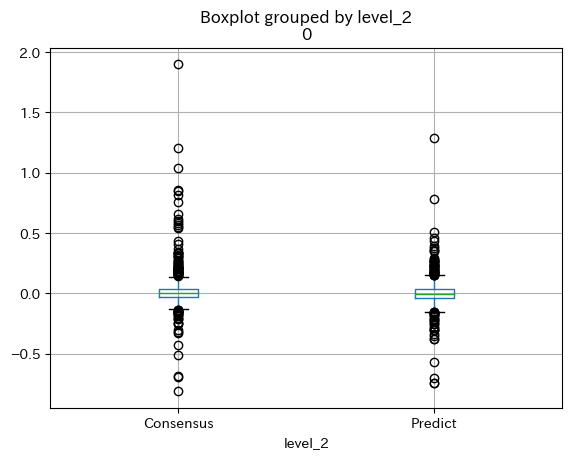

In [12]:
pre_win[['Predict', 'Consensus']].stack().reset_index(level=-1).boxplot(0, by='level_2')

In [13]:
matrix = ((pre_win['actual'] - pre_win['consensus']).map(np.sign) == (pre_win['predict'] - pre_win['consensus']).map(np.sign)).value_counts()
display(matrix.to_frame('direction_is_coincident'))
print(f'rate = {matrix[True] / sum(matrix)}')

,direction_is_coincident
True,562
False,304


rate = 0.648960739030023


Text(0.5, 1.0, 'コンセンサス予想 : 前年同期より増加\nPOSによる予想 : 前年同期より減少')

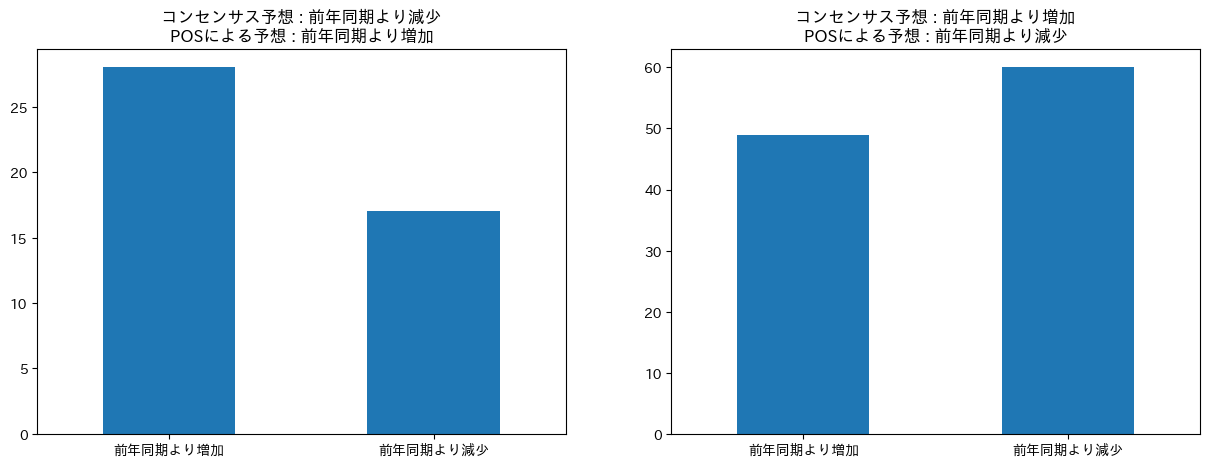

In [14]:
pre_win['actual_pre'] = sales.sort_index()['sales'].groupby('TICKER', group_keys=False).apply(lambda x: x.shift(4))
pre_win['actual_YoY'] = np.log(pre_win['actual']) - np.log(pre_win['actual_pre'])
pre_win['predict_YoY'] = np.log(pre_win['predict']) - np.log(pre_win['actual_pre'])
pre_win['consensus_YoY'] = np.log(pre_win['consensus']) - np.log(pre_win['actual_pre'])

_, axes = plt.subplots(1, 2, figsize=(15,5))
pre_win[(pre_win['consensus_YoY'] < 0) & (pre_win['predict_YoY'] > 0) ]['actual_YoY'].map(np.sign).map({1:'前年同期より増加', -1:'前年同期より減少'}).value_counts().sort_index().plot.bar(ax=axes[0], rot=0)
axes[0].set_title('コンセンサス予想 : 前年同期より減少\nPOSによる予想 : 前年同期より増加')
pre_win[(pre_win['consensus_YoY'] > 0) & (pre_win['predict_YoY'] < 0) ]['actual_YoY'].map(np.sign).map({1:'前年同期より増加', -1:'前年同期より減少'}).value_counts().sort_index().plot.bar(ax=axes[1], rot=0)
axes[1].set_title('コンセンサス予想 : 前年同期より増加\nPOSによる予想 : 前年同期より減少')

In [232]:
examples = pd.concat({'rate': prediction_with_consensus.groupby('TICKER')['win'].mean().sort_values(), 'count': prediction_with_consensus.groupby('TICKER')['win'].size()}, axis=1)
examples[examples['count']>=40].sort_values('rate').tail()

,rate,count
TICKER,,
6702,0.475000,40
3402,0.487805,41
4901,0.512195,41
8113,0.525000,40
4188,0.625000,40


Text(0, 0.5, 'YoY(logdiff)')

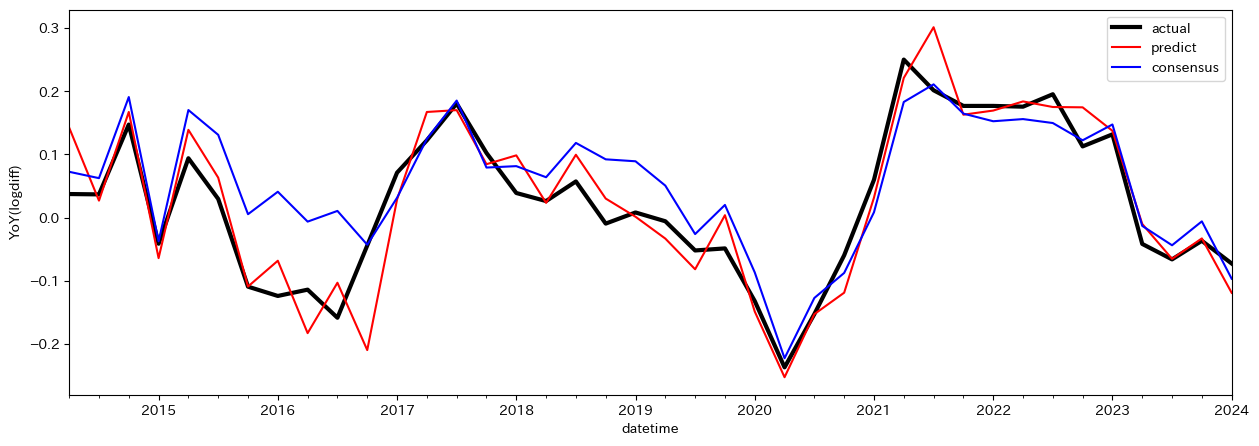

In [233]:
ticker = '4188'
sample = prediction_with_consensus.xs(ticker)[['actual', 'predict', 'consensus']].copy()
sample['pre'] = sales.xs(ticker).sort_index().shift(4)['sales']
sample[['pos', 'y']] = pos_data.xs(0).xs(False).xs(ticker)[['X', 'y']]

ax = (np.log(sample['actual']) - np.log(sample['pre'])).plot(color='black', linewidth=3, figsize=(15,5), label='actual')
(np.log(sample['predict']) - np.log(sample['pre'])).plot(color='red', ax=ax, label='predict')
(np.log(sample['consensus']) - np.log(sample['pre'])).plot(color='blue', ax=ax, label='consensus')
# sample['y'].plot(ax=ax, label='y', linestyle=':')
# sample['pos'].plot(ax=ax, label='POS', linestyle=':')
ax.legend()
plt.ylabel('YoY(logdiff)')

# コンセンサス不在の銘柄に対する予測
POSによる線形単回帰

In [15]:
prediction_without_consensus = {}
for (ticker, until), setting in tqdm(best_correlations.iterrows(), total=len(best_correlations)):
    lag, diff1 = setting['lag'], setting['diff1']
    d = pos_data.xs(lag).xs(diff1).xs(ticker).loc[:until]
    try:
        target = pos_data.xs(lag).xs(diff1).xs(ticker).loc[until:].iloc[1]
    except:
        continue
    datetime = target.name
    X, y = target[['X', 'y']]

    if len(d) < 20 or (ticker, datetime) in cons.index:
        continue

    mdl = sm.OLS(d['y'], sm.add_constant(d['X'].values), missing="drop").fit()
    y_predict = mdl.predict([1, X])

    ys = pos_data.xs(lag).xs(ticker, level='TICKER')['y'].unstack('diff').loc[:datetime].copy()
    try:
        sales_pre = sales.xs(ticker).loc[:datetime, 'sales'].iloc[-5]
        sales_actual = sales.xs(ticker).xs(datetime)['sales'] #np.exp(ys).loc[datetime, False] * sales_pre
        sales_extrapolation = np.exp(ys[False].iloc[-2]) * sales_pre # 前期の実績成長率(YoY) * 前年同期の売上
    except:
        continue
    
    ys.loc[datetime, diff1] = y_predict
    ys.loc[datetime, not diff1] = np.nan
    if diff1:
        ys.loc[datetime, False] = ys.loc[until, False] + ys.loc[datetime, True]
    sales_predict = np.exp(ys).loc[datetime, False] * sales_pre
    prediction_without_consensus[ticker, datetime] = {
        'actual': sales_actual, 
        'predict': sales_predict,
        "t_val": mdl.tvalues['x1'],
        "extrapolation": sales_extrapolation
    }
prediction_without_consensus = pd.DataFrame(prediction_without_consensus).T
prediction_without_consensus.index.names = ['TICKER', 'datetime']
prediction_without_consensus['Predict'] = (prediction_without_consensus['predict'] - prediction_without_consensus['actual']) / prediction_without_consensus['actual']
prediction_without_consensus['Extrapolation'] = (prediction_without_consensus['extrapolation'] - prediction_without_consensus['actual']) / prediction_without_consensus['actual'] 
prediction_without_consensus['share'] = share_ts.groupby('seccode', group_keys=False)['mean'].apply(lambda x: x.shift(1)).reindex(prediction_without_consensus.index)
prediction_without_consensus['Extrapolation'] = (prediction_without_consensus['extrapolation'] - prediction_without_consensus['actual']) / prediction_without_consensus['actual'] 

  0%|          | 0/10882 [00:00<?, ?it/s]

In [16]:
good = prediction_without_consensus[(prediction_without_consensus['share']>0.05)&(prediction_without_consensus['t_val']>0)].copy()

In [17]:
np.sqrt(((good[['Predict', 'Extrapolation']])**2).mean()).to_frame('RMSPE')

,RMSPE
Predict,0.122392
Extrapolation,0.143662
